Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or elise or stephan, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = ""

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [3]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [4]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [5]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [6]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)

    # Loop until for all states we have that the value function changed < theta
    while True:
        diff = 0
        
        #
        for s in range(0, env.nS):
            v = V[s]
            # Update V[s]
            new_Vs = 0
            for a in range(0, env.nA):
                # Go through each transition tuple from state s with action a
                for trans_tuple in env.P[s][a]:
                    prob, s_next, r, _ = trans_tuple
                    new_Vs = new_Vs + policy[s][a] * prob * (r + discount_factor*V[s_next])
            V[s] = new_Vs
            
            diff = max(diff, abs(v-V[s]))
        
        # Stop if convergence
        if diff < theta:
            break
        
    return np.array(V)

In [7]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

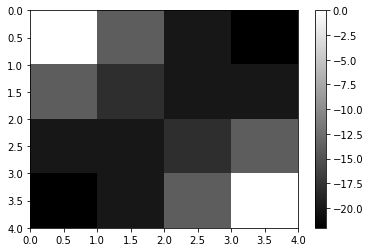

In [8]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [9]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [10]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA

    k=0
    while True:
        k=k+1
        print(k)
        # Policy evaluation step
        V = policy_eval(policy, env, discount_factor)
        
        # Policy improvement step
        policy_stable = True
        for s in range(0, env.nS):
            old_action_distr = policy[s].copy()
            temp = np.zeros(env.nA)
            for a in range(0, env.nA):
                # Calculate temp[a]
                for trans_tuple in env.P[s][a]:
                    prob, s_next, r, _ = trans_tuple
                    temp[a] = temp[a] + prob * (r + discount_factor*V[s_next])
            index_best_action = np.argmax(temp)
            
            policy[s] = np.zeros(env.nA)
            policy[s][index_best_action] = 1.0

            if (old_action_distr == policy[s]).all() != True:
                policy_stable = False
                
        # Stop when policy didnt change
        if policy_stable == True:
            break
    
    return policy, V

1
2
3
Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



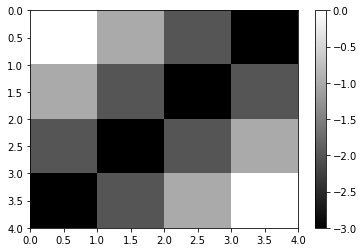

In [11]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [12]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [13]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    # Initialisation (Note: value of terminal states is indeed 0)
    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    # Implement!
    # YOUR CODE HERE
    k=0
    # loop to calc optimal value function
    while True:
        k=k+1
        print(k)
        delta = 0
        for s in range(0, env.nS):
            v = V[s]
            temp = np.zeros(env.nA)
            for a in range(0, env.nA):
                # Calculate temp[a]
                for trans_tuple in env.P[s][a]:
                    prob, s_next, r, _ = trans_tuple
                    temp[a] = temp[a] + prob * (r + discount_factor*V[s_next])
            index_best_action = np.argmax(temp)

            # Update V[s]
            V[s] = temp[index_best_action]
            delta = max(delta, abs(v-V[s]))
        
        # Stop when convergence
        if delta < theta:
            break

    # Given optimal value function, calculate an (deterministic) optimal policy
    for s in range(0, env.nS):
        temp = np.zeros(env.nA)
        for a in range(0, env.nA):
            # Calculate temp[a]
            for trans_tuple in env.P[s][a]:
                prob, s_next, r, _ = trans_tuple
                temp[a] = temp[a] + prob * (r + discount_factor*V[s_next])
        index_best_action = np.argmax(temp)
        policy[s][index_best_action] = 1.0
    
    return policy, V

In [14]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


1
2
3
4
Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

YOUR ANSWER HERE

Value iteration consists of an iterative process which is used to find the optimal value function and after that a single "policy extraction part" where an optimal policy is then defined.

Policy iteration on the other hand consists of performing policy evaluation and policy improvement steps in a loop until you find the optimal policy.

The difference is thus that in policy iteration a policy is iteratively improved, while in value iteration we just define the optimal policy once at the end.

To determine the efficiency, note that the main part of the computations for policy iteration is the policy evaluation, and for value iteration the iterative loop. The main difference between the loops, is that in value iteration we have an extra max over all actions. So if there are alot of actions, then the loop in value iteration will definitely need a lot more computations.

However, in this problem the number of actions is very small, so value iteration is probably quicker.

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

YOUR ANSWER HERE

Dynamic programming needs knowledge of the full model, because its updates are "wide" (i.e. considers from current state all possible actions). The updates are also "shallow" (i.e. to determine update for current state-value, only looks at state-values of states reached by 1 action).WE aslo use bootstrap strategy to evaluate state values, which means each state values is estimated based on the estimation of other state values.

Monte Carlo methods on the other hand firstly do not need any full model knowledge to work. Also its updates are "narrow" (for example we take 1 episode path) and "deep" (to determine the update, we need information of all steps of the whole episode).

We can use MC method, if we dont know the full model for example. If we have a complete accurate model about the environment, the possible states and actions are also limited, then dynamic programming should be used. 

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [50]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [2]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [52]:
# We can also look at the documentation/implementation of a method
?env.step

In [53]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [54]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    # YOUR CODE HERE

    cur_sum = observation[0]
    if cur_sum > 20:
        return 0 # action = stick
    else:
        return 1 # action = hit
    
    # Observation = ( current sum of own cards,  value of visible card dealer,  True:Has usable ace / False:No usable use  )
    

In [55]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(13, 7, False)
((16, 7, False), 0, False, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [56]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    # YOUR CODE HERE
    
    for n in tqdm(range(0, num_episodes)):
        # Generate an episode
        s = env.reset()
        new_episode_S = []
        new_episode_A = []
        new_episode_R = []
        while True:
            chosen_action = policy(s)
            next_state, r, done, _ = env.step(chosen_action)
            # Remember St,At,Rt+1
            new_episode_S.append(s)
            new_episode_A.append(chosen_action)
            new_episode_R.append(r)
            if done == True:
                break
            else:
                s = next_state

        G = 0
        T = len(new_episode_S)
        for t in reversed(list(range(0, T))):
            G = discount_factor*G + new_episode_R[t]
            # We do first visit MC
            St = new_episode_S[t]
            if (St in new_episode_S[0:t]) == False:
                returns_count[St] += 1
                returns_sum[St] += G
                V[St] = returns_sum[St] / returns_count[St]
                
    return V

In [57]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

100%|██████████| 1000/1000 [00:00<00:00, 9560.54it/s]

defaultdict(<class 'float'>, {(16, 7, False): -1.0, (15, 7, False): -0.8, (14, 7, False): -1.0, (19, 1, False): -1.0, (17, 1, False): -1.0, (20, 1, False): -0.9230769230769231, (19, 6, False): -0.8333333333333334, (19, 6, True): -0.3333333333333333, (15, 8, False): -0.3333333333333333, (20, 3, False): -0.8095238095238095, (21, 3, False): 1.0, (16, 3, False): -0.3333333333333333, (14, 6, False): -0.6, (20, 9, False): -1.0, (16, 5, False): -0.8888888888888888, (16, 9, False): -0.7777777777777778, (12, 9, False): -1.0, (14, 6, True): -1.0, (20, 8, False): -0.6666666666666666, (18, 4, False): -1.0, (17, 7, False): -0.75, (18, 10, False): -0.75, (15, 4, False): -0.5, (15, 4, True): 0.3333333333333333, (16, 2, False): -0.8333333333333334, (19, 2, True): -1.0, (21, 4, False): 0.8888888888888888, (12, 4, False): -0.7142857142857143, (17, 4, False): -1.0, (14, 8, False): -1.0, (18, 7, False): -1.0, (21, 2, True): 0.8, (18, 8, False): -0.6470588235294118, (20, 2, False): -0.8947368421052632, (16

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [58]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:30<00:00, 16251.57it/s]

CPU times: user 31.5 s, sys: 27.8 ms, total: 31.5 s
Wall time: 31.5 s


In [59]:
# YOUR CODE HERE

# 4 plots like in order in book:
#  A  B
#  C  D

# state = ( cur sum of own cards,  value of visible card dealer,  True:Has usable ace / False:No usable use  )
#                 12,..,21           1,...,10

grid_A_vals = np.zeros((10,10)) # dealer, cur sum own cards
grid_B_vals = np.zeros((10,10)) # dealer, cur sum own cards
grid_C_vals = np.zeros((10,10)) # dealer, cur sum own cards
grid_D_vals = np.zeros((10,10)) # dealer, cur sum own cards

for s in V_10k:
    vs = V_10k[s]
    sum_own_cards, val_vis_dealer_card, has_usable_ace = s
    if has_usable_ace == True:
        grid_A_vals[val_vis_dealer_card-1][sum_own_cards-12] = vs
    else:
        grid_C_vals[val_vis_dealer_card-1][sum_own_cards-12] = vs

for s in V_500k:
    vs = V_500k[s]
    sum_own_cards, val_vis_dealer_card, has_usable_ace = s
    if has_usable_ace == True:
        grid_B_vals[val_vis_dealer_card-1][sum_own_cards-12] = vs
    else:
        grid_D_vals[val_vis_dealer_card-1][sum_own_cards-12] = vs


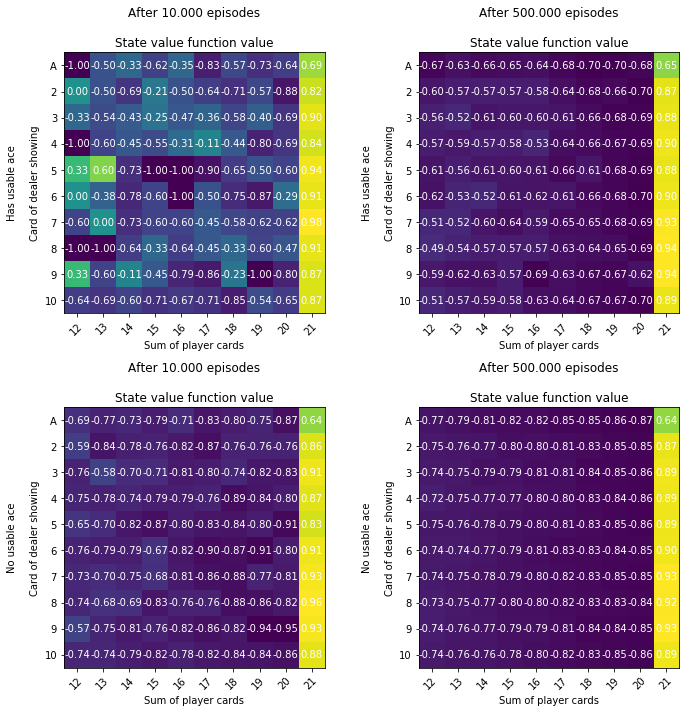

In [60]:
player_sum = [12,13,14,15,16,17,18,19,20,21]
dealer_showing = ["A",2,3,4,5,6,7,8,9,10]


fig = plt.figure(figsize=(10,10))

################################           FIG A
ax = fig.add_subplot(2,2,1)
grid_vals = grid_A_vals
im = ax.imshow(grid_vals)

# We want to show all ticks...
ax.set_xticks(np.arange(len(player_sum)))
ax.set_yticks(np.arange(len(dealer_showing)))
# ... and label them with the respective list entries
ax.set_xticklabels(player_sum)
ax.set_yticklabels(dealer_showing)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_showing)):
    for j in range(len(player_sum)):
        text = ax.text(j, i, "{:.2f}".format(grid_vals[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("After 10.000 episodes\n\nState value function value")
plt.ylabel("Has usable ace\n\nCard of dealer showing")
plt.xlabel("Sum of player cards")
################################           FIG B
ax = fig.add_subplot(2,2,2)
grid_vals = grid_B_vals
im = ax.imshow(grid_vals)

# We want to show all ticks...
ax.set_xticks(np.arange(len(player_sum)))
ax.set_yticks(np.arange(len(dealer_showing)))
# ... and label them with the respective list entries
ax.set_xticklabels(player_sum)
ax.set_yticklabels(dealer_showing)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_showing)):
    for j in range(len(player_sum)):
        text = ax.text(j, i, "{:.2f}".format(grid_vals[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("After 500.000 episodes\n\nState value function value")
plt.ylabel("Has usable ace\n\nCard of dealer showing")
plt.xlabel("Sum of player cards")
################################           FIG C
ax = fig.add_subplot(2,2,3)
grid_vals = grid_C_vals
im = ax.imshow(grid_vals)

# We want to show all ticks...
ax.set_xticks(np.arange(len(player_sum)))
ax.set_yticks(np.arange(len(dealer_showing)))
# ... and label them with the respective list entries
ax.set_xticklabels(player_sum)
ax.set_yticklabels(dealer_showing)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_showing)):
    for j in range(len(player_sum)):
        text = ax.text(j, i, "{:.2f}".format(grid_vals[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("After 10.000 episodes\n\nState value function value")
plt.ylabel("No usable ace\n\nCard of dealer showing")
plt.xlabel("Sum of player cards")
################################           FIG D
ax = fig.add_subplot(2,2,4)
grid_vals = grid_D_vals
im = ax.imshow(grid_vals)

# We want to show all ticks...
ax.set_xticks(np.arange(len(player_sum)))
ax.set_yticks(np.arange(len(dealer_showing)))
# ... and label them with the respective list entries
ax.set_xticklabels(player_sum)
ax.set_yticklabels(dealer_showing)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_showing)):
    for j in range(len(player_sum)):
        text = ax.text(j, i, "{:.2f}".format(grid_vals[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("After 500.000 episodes\n\nState value function value")
plt.ylabel("No usable ace\n\nCard of dealer showing")
plt.xlabel("Sum of player cards")
################################

fig.tight_layout()
plt.show()

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy.

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # YOUR CODE HERE
        
        # get argmax with random tiebreaking
        index_best_action = np.random.choice(np.flatnonzero(Q[observation] == Q[observation].max()))        

        action_probs = np.ones(nA)
        action_probs = action_probs * epsilon / nA
        action_probs[index_best_action] = 1 - epsilon + (epsilon / nA)

        return action_probs
        
    return policy_fn

In [63]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # YOUR CODE HERE

    for n in tqdm(range(0, num_episodes)):

        # Generate an episode
        # Get random state,action pair
        s = env.reset()
        a = np.random.randint(0, env.nA)
        
        new_episode_S = []
        new_episode_A = []
        new_episode_R = []
        while True:
            # Sample action
            action_distr = policy(s)
            chosen_action = np.random.choice(np.arange(0, env.nA), p=action_distr)
            
            next_state, r, done, _ = env.step(chosen_action)
            # Remember St,At,Rt+1
            new_episode_S.append(s)
            new_episode_A.append(chosen_action)
            new_episode_R.append(r)
            if done == True:
                break
            else:
                s = next_state

        G = 0
        T = len(new_episode_S)
        for t in reversed(list(range(0, T))):
            G = discount_factor*G + new_episode_R[t]
            # We do first visit MC
            St = new_episode_S[t]
            At = new_episode_A[t]
            if (St in new_episode_S[0:t]) == False and (At in new_episode_A[0:t]) == False:
                returns_count[St][At] += 1
                returns_sum[St][At] += G
                Q[St][At] = returns_sum[St][At] / returns_count[St][At]
                policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 10000/10000 [00:01<00:00, 6219.56it/s]


In [64]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [01:30<00:00, 5526.19it/s]

CPU times: user 1min 30s, sys: 200 ms, total: 1min 30s
Wall time: 1min 30s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

In [88]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [01:26<00:00, 5798.30it/s]


In [92]:
# YOUR CODE HERE

# value function from q function can be gained with:
# V(s) = sum_a p(a|s)*Q(s,a)
#

# Usable ace UA, nonusable ace NUA
grid_UA = np.zeros((10,10)) # val_vis_card_dealer, sum_own_cards
grid_NUA = np.zeros((10,10)) # val_vis_card_dealer, sum_own_cards
for val_vis_card_dealer in range(1, 10+1):
    for sum_own_cards in range(12, 21+1):
        state_UA = (sum_own_cards, val_vis_card_dealer, True)
        state_NUA = (sum_own_cards, val_vis_card_dealer, False)
        i_index = val_vis_card_dealer - 1
        j_index = sum_own_cards - 12
        for a_index in range(0, env.nA):
            grid_UA[i_index][j_index] += policy(state_UA)[a_index] * Q[state_UA][a_index]
            grid_NUA[i_index][j_index] += policy(state_NUA)[a_index] * Q[state_NUA][a_index]


# plot the greedy policy (stick for 0 = black, white for 1=hit)
action_grid_UA = np.zeros((10,10))+3 # val_vis_card_dealer, sum_own_cards
action_grid_NUA = np.zeros((10,10))+3 # val_vis_card_dealer, sum_own_cards
for val_vis_card_dealer in range(1, 10+1):
    for sum_own_cards in range(12, 21+1):
        state_UA = (sum_own_cards, val_vis_card_dealer, True)
        state_NUA = (sum_own_cards, val_vis_card_dealer, False)
        i_index = val_vis_card_dealer - 1
        j_index = sum_own_cards - 12

        if policy(state_UA)[0] < policy(state_UA)[1]:  # if p(stick) < p(hit)
            action_grid_UA[i_index][j_index] = 1 # hit
        else:
            action_grid_UA[i_index][j_index] = 0 # stick
            
        if policy(state_NUA)[0] < policy(state_NUA)[1]:  # if p(stick) < p(hit)
            action_grid_NUA[i_index][j_index] = 1 # hit
        else:
            action_grid_NUA[i_index][j_index] = 0 # stick

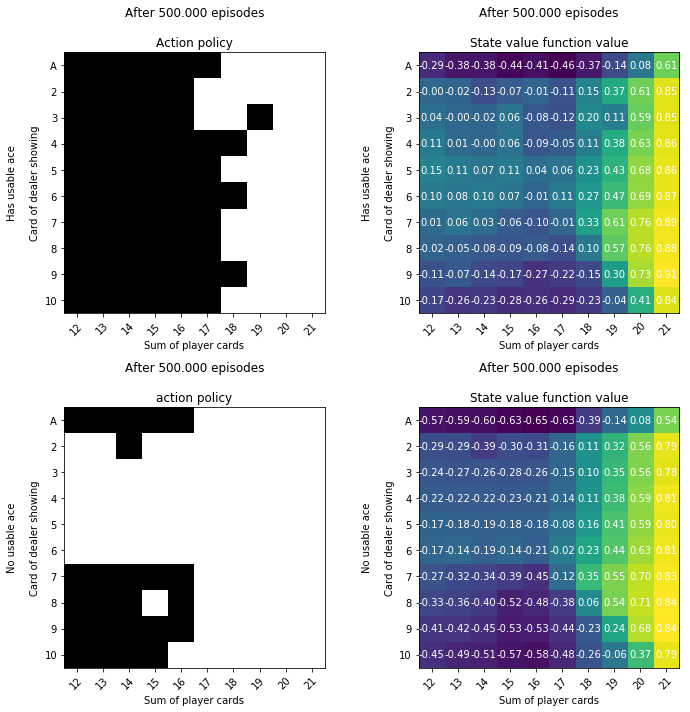

In [93]:
player_sum = [12,13,14,15,16,17,18,19,20,21]
dealer_showing = ["A",2,3,4,5,6,7,8,9,10]

fig = plt.figure(figsize=(10,10))

# figures as in book
#  A  B
#  C  D

################################           FIG A
ax = fig.add_subplot(2,2,1)
grid_vals = action_grid_UA
im = ax.imshow(grid_vals, cmap='Greys')

# We want to show all ticks...
ax.set_xticks(np.arange(len(player_sum)))
ax.set_yticks(np.arange(len(dealer_showing)))
# ... and label them with the respective list entries
ax.set_xticklabels(player_sum)
ax.set_yticklabels(dealer_showing)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("After 500.000 episodes\n\nAction policy")
plt.ylabel("Has usable ace\n\nCard of dealer showing")
plt.xlabel("Sum of player cards")
################################           FIG B
ax = fig.add_subplot(2,2,2)
grid_vals = grid_UA
im = ax.imshow(grid_vals)

# We want to show all ticks...
ax.set_xticks(np.arange(len(player_sum)))
ax.set_yticks(np.arange(len(dealer_showing)))
# ... and label them with the respective list entries
ax.set_xticklabels(player_sum)
ax.set_yticklabels(dealer_showing)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_showing)):
    for j in range(len(player_sum)):
        text = ax.text(j, i, "{:.2f}".format(grid_vals[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("After 500.000 episodes\n\nState value function value")
plt.ylabel("Has usable ace\n\nCard of dealer showing")
plt.xlabel("Sum of player cards")
################################           FIG D
ax = fig.add_subplot(2,2,3)
grid_vals = action_grid_NUA
im = ax.imshow(grid_vals, cmap='Greys')

# We want to show all ticks...
ax.set_xticks(np.arange(len(player_sum)))
ax.set_yticks(np.arange(len(dealer_showing)))
# ... and label them with the respective list entries
ax.set_xticklabels(player_sum)
ax.set_yticklabels(dealer_showing)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("After 500.000 episodes\n\naction policy")
plt.ylabel("No usable ace\n\nCard of dealer showing")
plt.xlabel("Sum of player cards")
################################           FIG D
ax = fig.add_subplot(2,2,4)
grid_vals = grid_NUA
im = ax.imshow(grid_vals)

# We want to show all ticks...
ax.set_xticks(np.arange(len(player_sum)))
ax.set_yticks(np.arange(len(dealer_showing)))
# ... and label them with the respective list entries
ax.set_xticklabels(player_sum)
ax.set_yticklabels(dealer_showing)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dealer_showing)):
    for j in range(len(player_sum)):
        text = ax.text(j, i, "{:.2f}".format(grid_vals[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("After 500.000 episodes\n\nState value function value")
plt.ylabel("No usable ace\n\nCard of dealer showing")
plt.xlabel("Sum of player cards")
################################

fig.tight_layout()
plt.show()

## 6. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

YOUR ANSWER HERE

Advantage: Simple method to understand which also does not need full model knowledge to work.

Disadvantage: Updates can only be made if the return is known, so only after a whole episode is finished.

We would prefer TD learning, when for example each episode length is very long. Since TD is "shallow", it does not need to wait for the episode to finish before it can update If we use temporal difference (TD), we could exploit learned values quickly in the intermediate steps. So an example where episode length is very long could be some game which requieres many steps.

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [6]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

In [95]:
?env.env

Object `env.env` not found.


100%|██████████| 1000/1000 [00:01<00:00, 542.47it/s]


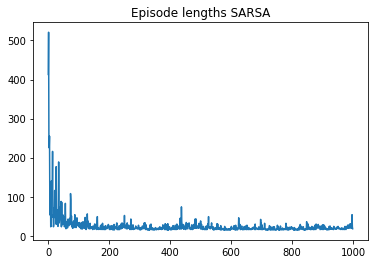

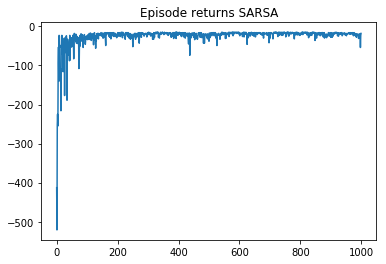

In [7]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 1#0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        # Choose an action a using policy from current Q
        action_distr = policy(s)
        a = np.random.choice(np.arange(0, env.nA), p=action_distr)
        while True:
            # With chosen action a, observe reward and next state
            next_s, r, done, _ = env.step(a)
            R = R + r
            
            # Determine next action if we were at next_state
            next_action_distr = policy(next_s)
            next_chosen_a = np.random.choice(np.arange(0, env.nA), p=next_action_distr)
            
            # Update Q
            Q[s][a] = Q[s][a] \
                + alpha * (r + discount_factor*Q[next_s][next_chosen_a] - Q[s][a])
            
            # Note: By design of "make_epsilon_greedy_policy", policy adapts
            # automatically whenever Q changes
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            
            if done == True:
                break
            else:
                s = next_s
                a = next_chosen_a
                i = i + 1
###

        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

Since we might not be interested in falling off the cliff all the time, we can find another person to do this 'exploration' for us (in the name of science). Still, we would like to learn ourselfs from this persons policy, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|██████████| 1000/1000 [00:01<00:00, 523.76it/s]


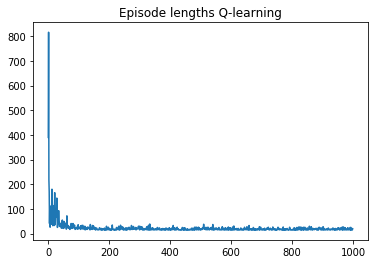

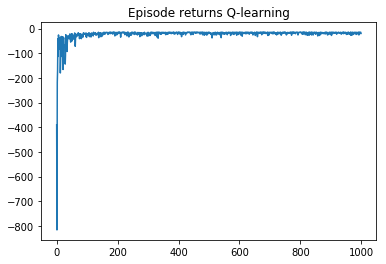

In [8]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 1#0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        # Choose an action a using policy from current Q
        action_distr = policy(s)
        a = np.random.choice(np.arange(0, env.nA), p=action_distr)
        while True:
            # With chosen action a, observe reward and next state
            next_s, r, done, _ = env.step(a)
            R = R + r
            
            # Determine next action if we were at next_state
            next_action_distr = policy(next_s)
            next_chosen_a = np.random.choice(np.arange(0, env.nA), p=next_action_distr)
            
            # Update Q
            index_best_action = np.random.choice(np.flatnonzero(Q[s] == Q[s].max()))
            Q[s][a] = Q[s][a] \
                + alpha * (r + discount_factor*Q[next_s][index_best_action] - Q[s][a])
            
            # Note: By design of "make_epsilon_greedy_policy", policy adapts
            # automatically whenever Q changes
            
            if done == True:
                break
            else:
                s = next_s
                a = next_chosen_a
                i = i + 1
###
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead). Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

100%|██████████| 5000/5000 [00:07<00:00, 698.32it/s]


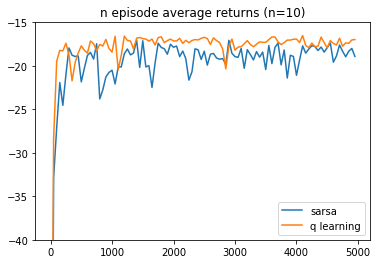

In [9]:
# YOUR CODE HERE

num_episodes = 5000

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, num_episodes)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, num_episodes)


# calc the n episode avgs (n=10)
n = 50
x = np.arange(0,num_episodes,n)
n_epi_avg_returns_sarsa = np.zeros(int(num_episodes/n))
n_epi_avg_returns_q_learning = np.zeros(int(num_episodes/n))
for i in range(0, len(n_epi_avg_returns_sarsa)):
    n_epi_avg_returns_sarsa[i] = sum(episode_returns_sarsa[i*n:(i+1)*n]) / n
    n_epi_avg_returns_q_learning[i] = sum(episode_returns_q_learning[i*n:(i+1)*n]) / n


plt.plot(x,n_epi_avg_returns_sarsa, label='sarsa')
plt.plot(x,n_epi_avg_returns_q_learning, label='q learning')
plt.title('n episode average returns (n=10)')
plt.ylim(-40,-15)
plt.legend()
plt.show()



YOUR ANSWER HERE

In here we have that Q learning achieves higher returns during learning.

In example 6.6 it was the other way round, since in example 6.6 it was sarsa which achieved higher returns during learning.

To explain the observations:
Q learning makes its updates by assuming the best action is to follow the greedy policy(off policy method since while learning we follow epsilon soft policy).
Sarsa on the other hand makes its updates by assuming it follows the same policy (on policy method).

This means that during training, q learning will more quickly converge to the optimal actions and therefore the returns in this example are better than sarsa.

However, in example 6.6 this was not the case. The reason is that the optimal path is very close to the cliff. And going off the cliff gave a very heavy penalty. Because during training, the actions are taken according to the epsilon soft policy (and not the best action is taken which updates of q learning are based on), we have that the randomness of epsilo will cause you to fall off the cliff sometimes that when you are closed to the cliff. sarsa method is updated based on the actually followed policy. It takes that into account and ensures a higher level of safety, and thus gets higher returns than q learning in that example.

Basically: in sarsa, more "attention" is given to the returns observed during learning, than that q learning does.

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

YOUR ANSWER HERE

We expected the two policy would perform similar but as the epsilon is set really small. The convergence of Q-learning could be an issue compared with SARSA, as it might learned the roundabout policy in the end. The accumulated rewards of Q-learning could be higher than SARSA as it always approaches the greedy policy.

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

In [11]:
Q_optimal_SARSA,(_,s_return)=sarsa(env, 100000)
Q_optimal_q_learning,(_,q_return)=q_learning(env, 100000)
number_transition=[]
total_reward = []
for state in range(70):
    i = 0
    R = 0
    while True:
        a=np.argmax(Q_optimal_SARSA[state])
        trans_prob, state_p, r , stop = env.P[state][a][0]
       # print(state)
        R+=r 
        i+=1
        state = state_p
        #print(stop)
        if stop == True:
            break
    number_transition.append(i)
    total_reward.append(R)

#raise NotImplementedError()
#print('Numbr of step to reach the final state SARSA: '+str(i))
#print('Accumulated rewards SARSA: '+str(R))

number_transition_q=[]
total_reward_q = []
for s in range(70):
    n = 0
    Reward = 0
    while True:
        action=np.argmax(Q_optimal_q_learning[s])
       # print(s)
        trans_prob, state_p, r , stop = env.P[s][action][0] 
        Reward+=r 
        n+=1
        s = state_p
        if stop == True:
            break
    number_transition_q.append(n)
    total_reward_q.append(Reward)
#raise NotImplementedError()
#print('Numbr of step to reach the final state Q learning: '+str(n))
#print('Accumulated rewards Q learning: '+str(Reward))
print('Numbr of step to reach the final state SARSA: '+str(number_transition))
print('Numbr of step to reach the final state Q learning: '+str(number_transition_q))
print('Accumulated rewards SARSA: '+str(total_reward))
print('Accumulated rewards Q learning: '+str(total_reward_q))
diff=0
for i in range(70):
    diff+=total_reward_q[i]-total_reward[i]
print('Difference of reward between SARSA and Q-learning: '+ str(diff))

100%|██████████| 100000/100000 [02:21<00:00, 707.76it/s]

Numbr of step to reach the final state SARSA: [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 15, 14, 13, 12, 11, 10, 9, 8, 7, 5, 15, 14, 13, 12, 11, 10, 9, 8, 6, 4, 15, 14, 13, 12, 11, 10, 10, 9, 5, 3, 15, 14, 13, 12, 11, 11, 10, 1, 1, 2, 15, 14, 13, 12, 12, 11, 10, 6, 3, 3, 16, 15, 14, 13, 12, 12, 11, 1, 4, 4]
Numbr of step to reach the final state Q learning: [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 15, 14, 13, 12, 11, 10, 9, 8, 7, 5, 15, 14, 13, 12, 11, 10, 9, 8, 6, 4, 15, 14, 13, 12, 11, 10, 9, 9, 5, 3, 15, 14, 13, 12, 11, 10, 10, 1, 1, 2, 16, 14, 13, 12, 11, 11, 10, 2, 3, 4, 15, 14, 13, 12, 12, 11, 10, 1, 2, 3]
Accumulated rewards SARSA: [-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -5.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -6.0, -4.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -10.0, -9.0, -5.0, -3.0, -15.0, -14.0, -13.0, -12.0, -11.0, -11.0, -10.0, -1.0, -1.0, -2.0, -15.0, -14.0, -13.0, -12.0, -1

In [41]:
# YOUR CODE HERE

path_sarsa = np.zeros((7,10)) # grid is 7 by 10

# calculate the path taken if folowing policy gained from sarsa
s = env.reset()
while True:
    # Get next action
    a = np.random.choice(np.flatnonzero(Q_q_learning[s] == Q_q_learning[s].max()))
    
    # With chosen action a, observe reward and next state
    next_s, r, done, _ = env.step(a)
    print("doing action " + str(a) + " which means we move from state: " + str(s) + " to state: " + str(next_s))
    if done == True:
        break
    else:
        s = next_s
    

doing action 1 which means we move from state: 30 to state: 31
doing action 1 which means we move from state: 31 to state: 32
doing action 1 which means we move from state: 32 to state: 33
doing action 1 which means we move from state: 33 to state: 24
doing action 1 which means we move from state: 24 to state: 15
doing action 1 which means we move from state: 15 to state: 6
doing action 1 which means we move from state: 6 to state: 7
doing action 1 which means we move from state: 7 to state: 8
doing action 1 which means we move from state: 8 to state: 9
doing action 2 which means we move from state: 9 to state: 19
doing action 2 which means we move from state: 19 to state: 29
doing action 2 which means we move from state: 29 to state: 39
doing action 2 which means we move from state: 39 to state: 49
doing action 3 which means we move from state: 49 to state: 48
doing action 3 which means we move from state: 48 to state: 37


In [42]:
#len(Q_sarsa)
Q_sarsa

defaultdict(<function __main__.sarsa.<locals>.<lambda>()>,
            {30: array([-20.71809783, -20.80045833, -19.89132578, -21.32577747]),
             31: array([-19.20276714, -17.95166547, -19.2272306 , -21.41300855]),
             32: array([-17.05465212, -17.06079633, -17.62018409, -19.63177478]),
             42: array([-18.06099498, -15.83589532, -17.44556285, -18.86472533]),
             33: array([-16.17503392, -16.16784485, -16.52265323, -17.11290207]),
             22: array([-16.45062497, -16.04853804, -17.15173759, -18.74147147]),
             12: array([-16.99691346, -16.18540858, -16.71732835, -17.03188589]),
             23: array([-15.52288616, -15.31412876, -16.34554056, -16.43418496]),
             14: array([-15.06889153, -14.17159685, -15.04777664, -15.61589776]),
             5: array([-15.30471403, -12.83832174, -14.1412799 , -16.25922716]),
             6: array([-14.44841926, -10.62937108, -13.84515778, -14.75475802]),
             4: array([-15.42510683, -14.

In [43]:
w = []
for k in Q_sarsa:
    w.append(k)
w.sort()



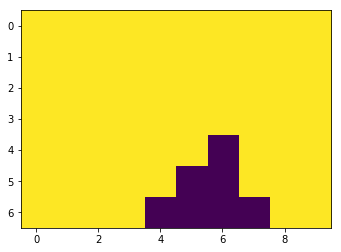

In [44]:
M = np.zeros((7,10))
for i in range(0,7):
    for j in range(0,10):
        e = 10*i+j
        if e in w:
            M[i][j] = 1
plt.imshow(M)